In [1]:
import os, sys
import traceback
from Module.allo_chain import *
from Module.count import *
from Module.denoise import *
from Module.network import *
from Module.IO_stat import *

plt.style.use('classic')
%matplotlib inline

In [2]:
def data_list(path):
    data_load = []
    for i in os.listdir(path):
        j = i.split('.')
        if j[-1] == 'txt':
            data_load.append(i)
    return data_load

In [3]:
data_path = './data' #The path of 'data' folder

Text_path = data_path + '/Text/'                   #put your text here
#----------------------------------------------------------------------
Ncompo_path = data_path + '/N_compo/'                  #the output folder of N-compo distribution plot
Chain_path = data_path + '/Chain/'                 #the output folder of chain-rank plot
Allo_path = data_path + '/Allocation/'             #the output folder of allocation-rank plot
RRD_path = data_path + '/RRD/'                     #the output folder of RRD plot
FRD_path = data_path + '/FRD/'                     #the output folder of FRD plot
Geo_path = data_path + '/Geometric seq/'           #the output folder of geometric sequence plot
SC_path = data_path + '/SC/'                       #the output document of rg plot and SC value
fitting_path = data_path + '/fitting/'             #the output document of scaling lines fitting
net_block_path = data_path + '/network block/'     #the output document of network analysis of block
net_compo_path = data_path + '/network component/' #the output document of network analysis of component
para_path = data_path + '/parameter/'              #the output document of GLC parameters

#----------------------------------------------------------------------
Big_path = data_path + '/Statistical result/'      #the output folder of all statistical data in execl


data_load = data_list(Text_path)
Text_load = [Text_path + i for i in data_load]
for i in data_load:
    print(i)

005_495_001_1.txt
01_495_0004_3.txt
01_49_0005_1.txt
01_43_0005_1.txt
004_49_001_1.txt
01_48_0005_1.txt
1_49_0005_1.txt
01_42_0001_1.txt
03_44_0005_1.txt
03_49_0005_1.txt
004_49_0015_1.txt
01_495_0011_1.txt


In [4]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)

def main():
    error_list = []
    #-------------------check if folders exist-----------------------------
    PATH = [Ncompo_path, Chain_path, Allo_path, RRD_path, FRD_path, Geo_path, SC_path,
            fitting_path, net_block_path, net_compo_path, para_path, Big_path]
    for P in PATH:
        try:           
            os.makedirs(P)  #create the folder
        except:
            print('***The folder "%s" already exist.' % P)
    #----------------------------------------------------------------------
    for Q in range(len(data_load)):
        try:
            filename = data_load[Q]
            name = filename.split('.txt')[0]
            big, compo, block, longest = info(Text_load[Q], encode)
            count_allo(block, compo)
            print('Successfully count allocation and chain!' + '(%s)' % filename)
            write_to_excel(big, block, compo, Big_path + name)
            #--------------plot N-compo plot
            FORMAT = 'png' #the format of your picture
            density = True
            Path = Ncompo_path
            
            N_compo_dist(name, big, longest, density, FORMAT, Path)
            #--------------plot geometric_sequence
            V, H = geometric_sequence(block, compo)
            max_range = 50 #the number of elements in the sequence you want to know
            x = 'H'
            FORMAT = 'png' #the format of your picture
            shift = 'N' #If you don't want to measure shift, just assign shift != 'T'.
            Path = Geo_path
            
            RH = which_plot(name, V, H, x, max_range, shift, FORMAT, Path)
            #--------------plot FRD plot
            FORMAT = 'pdf' #the format of your picture
            #auto positioning when (x_pos, y_pos)=(0, 0)
            x_pos = 0
            y_pos = 0
            Path = FRD_path

            FRD_block = FRD_plot(name, block, compo, x_pos, y_pos, FORMAT, Path)
            Zipf = FRD_block['ab'] #(a, b) of a*x ^-b
            #--------------plot RRD plot
            need_line = 'Y'
            number_of_lines = 4
            Color = '#ff0000'
            FORMAT = 'pdf' #the format of your picture
            Path = RRD_path

            RRD_coordinate = draw_RRD_plot(big, block, compo, longest, name, V, H,
                           need_line, number_of_lines, Color, FORMAT, Path)
            #--------------plot allocation-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Allo_path

            Allo_fit = Allo_plot(name, compo, x_pos, y_pos, FORMAT, Path)
            #--------------plot chain-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Chain_path

            Chain_fit = Chain_plot(name, block, x_pos, y_pos, FORMAT, Path)
            #--------------calculate SC and fitting scaling lines
            FORMAT = 'pdf' #the format of your picture
            L = 4
            toler = 50
            num_part = 50
            num_section = 2
            delta = 0.15
            percent = 0.05

            g, glu = plot_g(L, V, H, big, name, longest, toler, num_part, num_section, delta, percent)
            Rg = rg(name, g, FORMAT, SC_path)
            
            fit_para_best = fit_with_cut(glu, Rg[0], V, H, Zipf, name, FORMAT, fitting_path)
            #--------------Network analysis
            graph_block, graph_compo = build_edge(RRD_coordinate)
            G_block, cluster_block, block_degree_sequence = graph_block[0], graph_block[1], graph_block[2]
            G_compo, cluster_compo, compo_degree_sequence = graph_compo[0], graph_compo[1], graph_compo[2]            
            FORMAT = 'pdf'
            
            Path = net_block_path
            plot_degree_block(name, block_degree_sequence, FORMAT, Path)
            
            Path = net_compo_path
            degree_component = plot_degree_compo(name, compo_degree_sequence, FORMAT, Path)
            #--------------Record all GLC parameters and RRD points
            data_set = {}
            coordinate_set = {}
            
            data_set['FRD_block'] = FRD_block
            coordinate_set['RRD_coordinate'] = RRD_coordinate
            data_set['Allo_fit'] = Allo_fit
            data_set['Chain_fit'] = Chain_fit
            coordinate_set['glu'] = glu
            data_set['Rg'] = Rg
            data_set['fit_para_best'] = fit_para_best
            data_set['degree_component'] = degree_component

            #save para_ (GLC paras) and coor_ (RRD points)
            Path = para_path
            para_filename = 'para_' + filename
            save_parameters(para_filename, data_set, Path)            
            coor_filename = 'coor_' + filename
            save_parameters(coor_filename, coordinate_set, Path)
            
            print('Successfully run all!' + '(%s)' % filename)
        #--------------add filename to error_list when error      
        except Exception as exc:
            traceback.print_exc()
            error_list.append(data_load[Q])
            print('')
    if error_list != []:
        print('The following file get error when running:')
        for i in error_list:
            print(i)

read file successfully!
Successfully count block freqency!(./data/Text/005_495_001_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(005_495_001_1.txt)
the (5, 6) rectangle has no point.
the (5, 8) rectangle has no point.


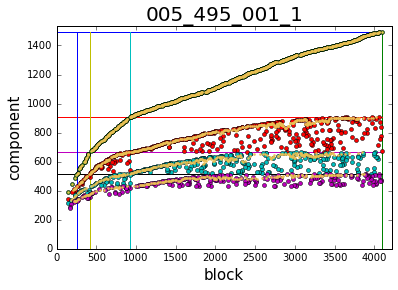

fitting range = [1023, 4095]
Successfully run all!(005_495_001_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_495_0004_3.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_495_0004_3.txt)
the (5, 7) rectangle has no point.


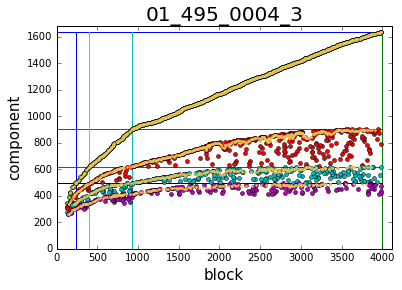

fitting range = [998, 3994]
Successfully run all!(01_495_0004_3.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_49_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_49_0005_1.txt)


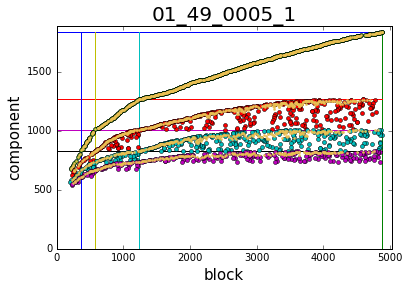

fitting range = [1219, 4878]
Successfully run all!(01_49_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_43_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_43_0005_1.txt)
the (5, 5) rectangle has no point.
the (4, 5) rectangle has no point.
the (4, 5) rectangle has no point.
the (5, 6) rectangle has no point.
the (5, 7) rectangle has no point.
the (5, 7) rectangle has no point.
the (5, 8) rectangle has no point.
the (5, 8) rectangle has no point.


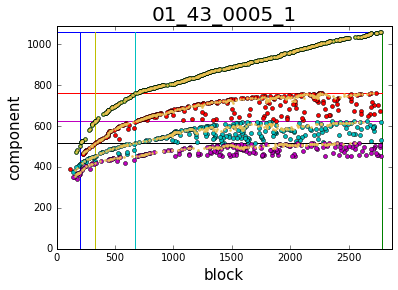

fitting range = [695, 2783]
Successfully run all!(01_43_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/004_49_001_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(004_49_001_1.txt)


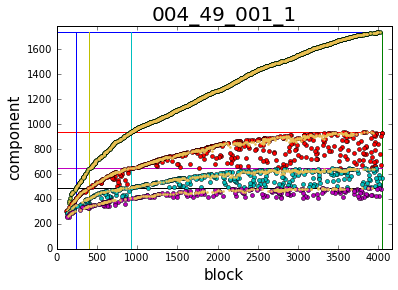

fitting range = [1010, 4042]
Successfully run all!(004_49_001_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_48_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_48_0005_1.txt)


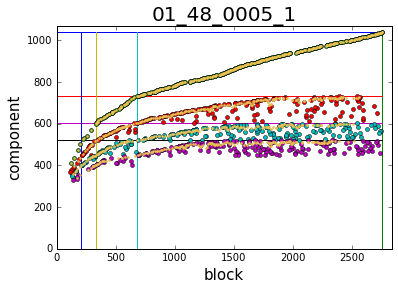

fitting range = [687, 2751]
Successfully run all!(01_48_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/1_49_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(1_49_0005_1.txt)


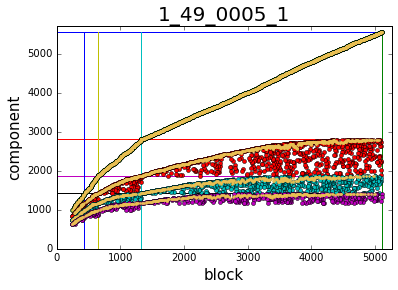

fitting range = [1276, 5104]
Successfully run all!(1_49_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_42_0001_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_42_0001_1.txt)
the (5, 5) rectangle has no point.
the (4, 5) rectangle has no point.
the (5, 6) rectangle has no point.
the (4, 5) rectangle has no point.
the (5, 6) rectangle has no point.
the (4, 6) rectangle has no point.
the (5, 8) rectangle has no point.
the (5, 8) rectangle has no point.


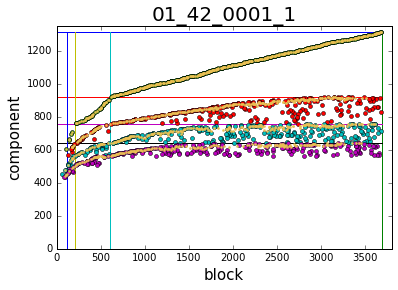

fitting range = [921, 3686]
Successfully run all!(01_42_0001_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/03_44_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(03_44_0005_1.txt)


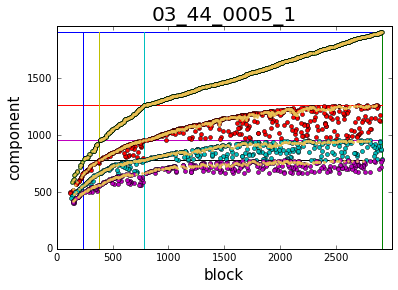

fitting range = [727, 2911]
Successfully run all!(03_44_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/03_49_0005_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(03_49_0005_1.txt)


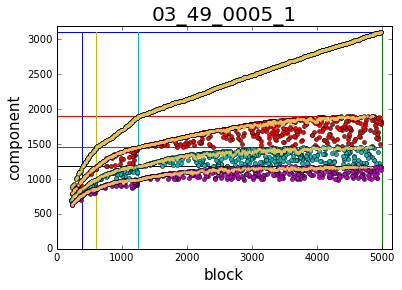

fitting range = [1248, 4994]
Successfully run all!(03_49_0005_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/004_49_0015_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(004_49_0015_1.txt)


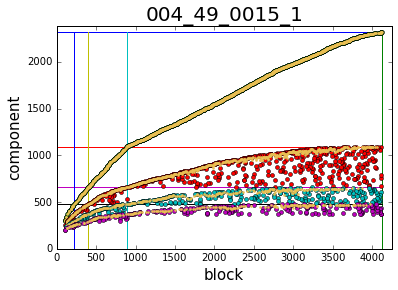

fitting range = [1030, 4121]
Successfully run all!(004_49_0015_1.txt)
read file successfully!
Successfully count block freqency!(./data/Text/01_495_0011_1.txt)
Successfully count compo freqency!
Successfully build data frames!
Successfully count allocation and chain!(01_495_0011_1.txt)


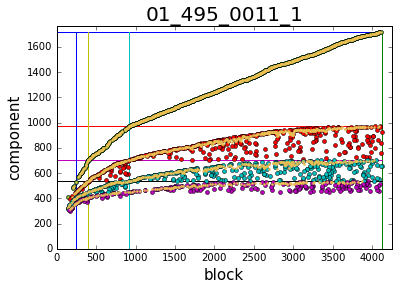

fitting range = [1031, 4124]
Successfully run all!(01_495_0011_1.txt)


In [5]:
main()